In [ ]:
!pip install  duckdb --upgrade --pre
!pip install  deltalake --upgrade
!pip install  polars --upgrade --pre

In [ ]:
from psutil import *
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

2 vCPU Memory:13.0


In [1]:
raw_landing='/lakehouse/default/Files/raw'

# Download Data

In [ ]:
import re ,os
import requests
from urllib.request import urlopen
def download(url,Path):
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = dict.fromkeys(filelist1)
    print(str(len(filelist_unique)) + ' New File Loaded')
    if len(filelist_unique) != 0 :
      for x in filelist_unique:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)
    return "done"

In [ ]:
download("https://nemweb.com.au/Reports/Current/Daily_Reports/",raw_landing+"/zip/")

60 New File Loaded


'done'

_**UNZIP**_

In [ ]:
from shutil import unpack_archive
import os , glob
def unzip(Source, Destination):
    filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    for x in filelist:
          try:
            unpack_archive(str(Source+x), str(Destination), 'zip')
          except:
            pass
    return "done"

In [ ]:
unzip(raw_landing+"/zip/",raw_landing+"/csv/")

'done'

# DuckDB

In [2]:
%%time
import duckdb
from deltalake.writer import write_deltalake
def duckdb_clean_csv(x):
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)
	columns = list(set(raw.columns) - {'SETTLEMENTDATE','DUID','I','filename','UNIT'})
	exprs = [
		duckdb.ColumnExpression(x).cast(duckdb.typing.DOUBLE).alias(x)
		for x in columns
	         ]
	rel2 = raw.select('SETTLEMENTDATE','DUID','I','filename','UNIT',*exprs)

	scada=duckdb.sql(""" select *exclude(SETTLEMENTDATE,I,XX,filename),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as YEAR  from rel2  """)
	return scada.arrow()


CPU times: user 590 ms, sys: 135 ms, total: 725 ms
Wall time: 1.83 s


# Polars

In [3]:
%%time
import polars as pl
def polars_clean_csv(x):
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x,
                    skip_rows=1,
                    schema=schema,
                    has_header=False,
                    truncate_ragged_lines=True)
  transform =(
      raw
      .filter(pl.col("I")=='D')
      .filter(pl.col("UNIT")=='DUNIT')
      .filter(pl.col("VERSION")=='3')
      .drop("XX")
      .drop("I")
  )
  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.columns) - {'SETTLEMENTDATE','DUID','UNIT'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),YEAR=pl.col("SETTLEMENTDATE").dt.iso_year()).collect()
  final.write_delta("/lakehouse/default/Tables/scada_polars", mode="append",delta_write_options={"partition_by" : ['YEAR']},storage_options={"allow_unsafe_rename":"true"})

CPU times: user 129 ms, sys: 33.7 ms, total: 162 ms
Wall time: 392 ms


# Pandas

In [4]:
import pandas as pd
import numpy as np
from deltalake.writer import write_deltalake
def Pandas_clean_csv(chunk):
     appended_data = []
     for filename in chunk:
      df = pd.read_csv(filename,skiprows=1,dtype=str, names=range(131))
      ################ Extract scada Table
      df = df.iloc[:, : 53]
      df.columns = df.iloc[0]
      df = df[1:]
      df_unit=df.query('DISPATCH=="DUNIT"')
      df_unit = df_unit.rename(columns={'1': 'version'})
      df_unit = df_unit.query('version=="3"')
      df_unit.columns = df_unit.iloc[0]
      df_unit = df_unit[1:]
      df_unit = df_unit.rename(columns={'3': 'version'})
      df_unit = df_unit.loc[:, df_unit.columns.notnull()]
      df_unit.drop(columns=['I'],inplace=True)
      df_unit.rename(columns={'DUNIT': 'UNIT'}, inplace=True)
      df_unit['SETTLEMENTDATE']=pd.to_datetime(df_unit['SETTLEMENTDATE'])
      columns = list(set(df_unit.columns) - {'SETTLEMENTDATE','DUID','UNIT'})
      df_unit[columns] = df_unit[columns].apply(pd.to_numeric, errors='coerce', axis=1)
      df_unit['YEAR']=df_unit['SETTLEMENTDATE'].dt.year
      appended_data.append(df_unit)
     appended_data = pd.concat(appended_data,ignore_index=True)
     return appended_data

# Clean CSV

In [5]:
import glob,os
Source = raw_landing+"/csv/"
list_files=[os.path.basename(x) for x in glob.glob(Source+'*.CSV')]
files_to_upload_full_Path = [Source + i for i in list_files]

In [6]:
chunk_len = 20
results = pd.DataFrame(columns=['Engine','step','duration'])

In [7]:
import time
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    write_deltalake("/lakehouse/default/Tables/scada_duckdb",duckdb_clean_csv(chunk),mode="append",partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    print('DuckDB :' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['DuckDB',i,time.time()-start]], columns=results.columns), results])
    ##########################
    start = time.time()
    polars_clean_csv(chunk)
    print('Polars :' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Polars',i,time.time()-start]], columns=results.columns), results])
    #########################
    start = time.time()
    write_deltalake("/lakehouse/default/Tables/scada_Pandas",Pandas_clean_csv(chunk), mode="append", partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    print('Pandas :' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pandas',i,time.time()-start]], columns=results.columns), results])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB :32.83765888214111
Polars :92.88614106178284
Pandas :556.5260479450226


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB :36.622562408447266
Polars :84.09282422065735
Pandas :558.9401788711548


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB :27.88830256462097
Polars :78.38024854660034
Pandas :517.3339431285858


# Results

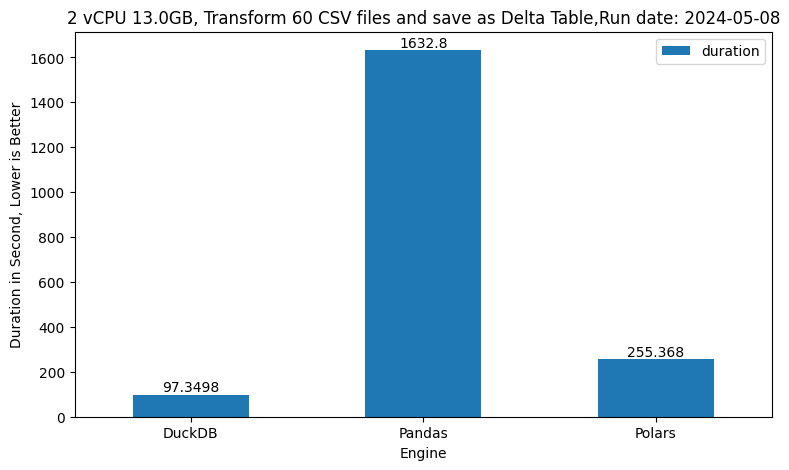

In [8]:
result = results.groupby(['Engine'])['duration'].sum().reset_index()
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ ', Transform 60 CSV files and save as Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))
ax = result.plot.bar(rot=0,x='Engine',title=runtime,ylabel='Duration in Second, Lower is Better',figsize=(9,5))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')